## 3. Pairwise replay within 200ms and Singleton replay

### (Use TrialChoiceReplay and find pairwise replay and singleton replays, results of pairs are in `TrialChoiceReplayTransition`)
[This notebook uses TrialChoiceReplay().]
##### All the tables mentioned above are under shijiegu github/spyglass/shijiegu/Analysis_SGU.py. It is not in the Franklab spyglass.

Jun 27, 2024 + Oct 31, 2024
Shijie Gu

In [3]:
%reload_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spikeinterface as si
import pynwb
import xarray as xr
import os

from spyglass.utils.nwb_helper_fn import get_nwb_copy_filename

In [5]:
from spyglass.shijiegu.Analysis_SGU import TrialChoice,RippleTimes,EpochPos,TrialChoiceReplayTransition
from spyglass.shijiegu.helpers import interval_union,interpolate_to_new_time
from spyglass.shijiegu.load import load_LFP,load_position
from spyglass.shijiegu.ripple_detection import (loadRippleLFP,ExtendInterSection,InterSection,
                                                plot_ripple,threshold_by_zscore_Gu,
                                                Kay_ripple_detector,Karlsson_ripple_detector,Gu_ripple_detector,multiunit_HSE_detector,
                                                removeDataBeforeTrial1,removeArtifactTime,
                                                loadRippleLFP_OneChannelPerElectrode,ripple_detection_master)
from spyglass.shijiegu.Analysis_SGU import TetrodeNumber,MUA,ExtendedTrialChoiceReplay,ExtendedRippleTimes
from spyglass.common.common_position import IntervalLinearizedPosition
from spyglass.common.common_task import TaskEpoch

[2024-11-18 15:32:07,836][INFO]: Connecting shijiegu-alt@lmf-db.cin.ucsf.edu:3306
[2024-11-18 15:32:07,898][INFO]: Connected shijiegu-alt@lmf-db.cin.ucsf.edu:3306


In [6]:
from spyglass.shijiegu.pairwiseDecode import merge_overlapping_ranges,removeEmptyDecode
from spyglass.shijiegu.ripple_add_replay import remove_adjacent
from spyglass.shijiegu.pairwiseDecode import findReplayPair
from spyglass.shijiegu.decodeHelpers import runSessionNames

In [526]:
nwb_file_name = 'haydn20230606.nwb'

In [527]:
nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)

In [528]:
session_interval, position_interval = runSessionNames(nwb_copy_file_name)

In [529]:
ExtendedTrialChoiceReplay() & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,classifier_param_name a name for this set of parameters,encoding_set a name for this set of encoding,decode_threshold_method a name for this thresholding method,"choice_reward_replay pandas dataframe, choice, reward, ripple time, replays"
haydn20230606_.nwb,02_Rev3Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,MUA_0SD,=BLOB=
haydn20230606_.nwb,04_Rev3Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,MUA_0SD,=BLOB=
haydn20230606_.nwb,06_Rev3Session3,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,MUA_0SD,=BLOB=
haydn20230606_.nwb,08_Rev3Session4,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,MUA_0SD,=BLOB=
haydn20230606_.nwb,10_Rev3Session5,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,MUA_0SD,=BLOB=


### for all sessions

In [531]:
#encoding_set = '2Dheadspeed_above_4_andlowmua'
decode_threshold_method = 'MUA_0SD'

encoding_set = '2Dheadspeed_above_4'
#decode_threshold_method = 'MUA_M05SD'
transitions_all=np.zeros((4,4))

classifier_param_name = 'default_decoding_gpu_4armMaze' #'causal_decoding_gpu_4armMaze' #'default_decoding_gpu_4armMaze'


for epoch_name in session_interval:
    print(epoch_name)

    key = {'nwb_file_name': nwb_copy_file_name,
           'interval_list_name': epoch_name,
           'classifier_param_name':classifier_param_name,
           'decode_threshold_method':decode_threshold_method,
           'encoding_set':encoding_set}

    transitions_session_old = (TrialChoiceReplayTransition & key).fetch1('transitions')
    T = pd.DataFrame((ExtendedTrialChoiceReplay & key).fetch1('choice_reward_replay'))
    
    T_transition, transitions_session = findReplayPair(T)
    
    key['transitions'] = transitions_session
    key['choice_reward_replay_transition'] = T_transition.to_dict()
    key.pop('decode_threshold_method')

    print(transitions_session_old)
    print(transitions_session)
    
    TrialChoiceReplayTransition().make(key,replace=True)
    
    transitions_all = transitions_all + transitions_session

02_Rev3Session1
[[28.  1.  3.  2.]
 [ 1. 16.  0.  1.]
 [ 5.  2. 29.  2.]
 [ 3.  1.  2. 16.]]
[[28.  1.  3.  2.]
 [ 1. 16.  0.  1.]
 [ 5.  2. 29.  2.]
 [ 3.  1.  2. 16.]]
04_Rev3Session2
[[21.  0.  4.  0.]
 [ 0.  7.  0.  1.]
 [ 6.  3. 16.  1.]
 [ 0.  0.  1.  3.]]
[[21.  0.  4.  0.]
 [ 0.  7.  0.  1.]
 [ 6.  3. 16.  1.]
 [ 0.  0.  1.  3.]]
06_Rev3Session3
[[23.  1.  4.  1.]
 [ 1.  8.  0.  2.]
 [ 6.  0.  7.  2.]
 [ 2.  1.  0. 11.]]
[[23.  1.  4.  1.]
 [ 1.  8.  0.  2.]
 [ 6.  0.  7.  2.]
 [ 2.  1.  0. 11.]]
08_Rev3Session4
[[25.  0.  3.  1.]
 [ 0.  1.  0.  2.]
 [ 1.  1. 16.  4.]
 [ 5.  1.  1. 21.]]
[[25.  0.  3.  1.]
 [ 0.  1.  0.  2.]
 [ 1.  1. 16.  4.]
 [ 5.  1.  1. 21.]]
10_Rev3Session5
[[28.  2.  4.  1.]
 [ 1.  7.  1.  3.]
 [ 5.  1.  9.  5.]
 [ 1.  0.  1. 11.]]
[[28.  2.  4.  1.]
 [ 1.  7.  1.  3.]
 [ 5.  1.  9.  5.]
 [ 1.  0.  1. 11.]]


In [508]:
epoch_name = "08_Rev3Session4"

In [509]:
key = {'nwb_file_name': nwb_copy_file_name,
           'interval_list_name': epoch_name,
           'classifier_param_name':classifier_param_name,
           'decode_threshold_method':decode_threshold_method,
           'encoding_set':encoding_set}
T_transition_old = (TrialChoiceReplayTransition() & key).fetch1("choice_reward_replay_transition")

In [510]:
T_transition[40:]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,replayed_transitions_time,replayed_singletons,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
41,1.686086e+09,1.0,1.686086e+09,3.0,[],[],"[1, 3]",2.0,"[[[1686086201.803292, 1686086202.0872917]], [[...","[[[1686086209.975285, 1686086210.2232847]], [[...","[[[1]], [[3], []]]","[[[1]], [[1, 3]], [[3]]]","[150, 151]","[152, 153, 154]",3.0,3.0,2.0,4.0,4.0
42,1.686086e+09,1.0,1.686086e+09,2.0,[],[],[],2.0,"[[[1686086221.1532753, 1686086221.3932753]], [...",[],"[[[0]], [[0]]]",[],"[155, 156]",[],2.0,2.0,1.0,3.0,3.0
43,1.686086e+09,1.0,1.686086e+09,1.0,[],[],[3],2.0,"[[[1686086242.0372574, 1686086242.2872572]], [...","[[[1686086252.0932488, 1686086252.3512485]], [...","[[[0]], [[0], [], [3], []]]","[[[1]], [[1]]]","[157, 158]","[159, 160]",1.0,1.0,4.0,2.0,2.0
44,1.686086e+09,1.0,1.686086e+09,4.0,[],[],[],2.0,"[[[1686086267.8392353, 1686086267.9852352]]]","[[[1686086277.7892268, 1686086278.0672266]], [...",[[[0]]],"[[[4]], [[4], [4]]]",[161],"[162, 163]",4.0,4.0,3.0,1.0,1.0
45,1.686086e+09,1.0,1.686086e+09,3.0,[],[],"[3, 1]",2.0,"[[[1686086288.7152174, 1686086288.7832174], [1...",[],"[[[], [3], [], [0, 1]]]",[],[164],[],3.0,3.0,2.0,4.0,4.0
46,1.686086e+09,1.0,1.686086e+09,2.0,[],[],[1],2.0,"[[[1686086309.4771996, 1686086309.8271992]], [...","[[[1686086323.0531878, 1686086323.3191876]]]","[[[1, 0]], [[0]]]",[[[2]]],"[166, 167]",[168],2.0,2.0,1.0,3.0,3.0
47,1.686086e+09,1.0,1.686086e+09,1.0,[],[],[4],2.0,"[[[1686086329.233183, 1686086329.4731824]], [[...","[[[1686086340.1131732, 1686086340.217173], [16...","[[[0]], [[4]]]","[[[4], []], [[], [2], []]]","[169, 170]","[171, 172]",1.0,1.0,4.0,2.0,2.0
48,1.686086e+09,1.0,1.686086e+09,4.0,[],[],"[1, 1]",2.0,"[[[1686086349.4151654, 1686086349.5651653]], [...","[[[1686086367.5131495, 1686086367.8611495]], [...","[[[0]], [[1]], [[0, 1]]]","[[[4]], [[4]], [[4]]]","[173, 174, 175]","[176, 177, 178]",4.0,4.0,3.0,1.0,1.0
49,1.686086e+09,1.0,1.686086e+09,3.0,[],[],[],2.0,"[[[1686086376.9131415, 1686086377.1431415]]]","[[[1686086390.72713, 1686086391.0191298]], [[1...",[[[0]]],"[[[1]], [[1]]]",[179],"[180, 181]",3.0,3.0,1.0,4.0,4.0
50,1.686086e+09,1.0,1.686086e+09,1.0,[],[],[],1.0,[],[],[],[],[],[],1.0,1.0,2.0,3.0,3.0


In [511]:
pd.DataFrame(T_transition_old)[40:]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,replayed_singletons,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
41,1.686086e+09,1.0,1.686086e+09,3.0,[],"[1, 3]",2.0,"[[[1686086201.803292, 1686086202.0872917]], [[...","[[[1686086209.975285, 1686086210.2232847]], [[...","[[[1]], [[3], []]]","[[[1]], [[1, 3]], [[3]]]","[150, 151]","[152, 153, 154]",3.0,3.0,2.0,4.0,4.0
42,1.686086e+09,1.0,1.686086e+09,2.0,[],[],2.0,"[[[1686086221.1532753, 1686086221.3932753]], [...",[],"[[[0]], [[0]]]",[],"[155, 156]",[],2.0,2.0,1.0,3.0,3.0
43,1.686086e+09,1.0,1.686086e+09,1.0,[],[3],2.0,"[[[1686086242.0372574, 1686086242.2872572]], [...","[[[1686086252.0932488, 1686086252.3512485]], [...","[[[0]], [[0], [], [3], []]]","[[[1]], [[1]]]","[157, 158]","[159, 160]",1.0,1.0,4.0,2.0,2.0
44,1.686086e+09,1.0,1.686086e+09,4.0,[],[],2.0,"[[[1686086267.8392353, 1686086267.9852352]]]","[[[1686086277.7892268, 1686086278.0672266]], [...",[[[0]]],"[[[4]], [[4], [4]]]",[161],"[162, 163]",4.0,4.0,3.0,1.0,1.0
45,1.686086e+09,1.0,1.686086e+09,3.0,[],"[3, 1]",2.0,"[[[1686086288.7152174, 1686086288.7832174], [1...",[],"[[[], [3], [], [0, 1]]]",[],[164],[],3.0,3.0,2.0,4.0,4.0
46,1.686086e+09,1.0,1.686086e+09,2.0,[],[1],2.0,"[[[1686086309.4771996, 1686086309.8271992]], [...","[[[1686086323.0531878, 1686086323.3191876]]]","[[[1, 0]], [[0]]]",[[[2]]],"[166, 167]",[168],2.0,2.0,1.0,3.0,3.0
47,1.686086e+09,1.0,1.686086e+09,1.0,[],[4],2.0,"[[[1686086329.233183, 1686086329.4731824]], [[...","[[[1686086340.1131732, 1686086340.217173], [16...","[[[0]], [[4]]]","[[[4], []], [[], [2], []]]","[169, 170]","[171, 172]",1.0,1.0,4.0,2.0,2.0
48,1.686086e+09,1.0,1.686086e+09,4.0,[],"[1, 1]",2.0,"[[[1686086349.4151654, 1686086349.5651653]], [...","[[[1686086367.5131495, 1686086367.8611495]], [...","[[[0]], [[1]], [[0, 1]]]","[[[4]], [[4]], [[4]]]","[173, 174, 175]","[176, 177, 178]",4.0,4.0,3.0,1.0,1.0
49,1.686086e+09,1.0,1.686086e+09,3.0,[],[],2.0,"[[[1686086376.9131415, 1686086377.1431415]]]","[[[1686086390.72713, 1686086391.0191298]], [[1...",[[[0]]],"[[[1]], [[1]]]",[179],"[180, 181]",3.0,3.0,1.0,4.0,4.0
50,1.686086e+09,1.0,1.686086e+09,1.0,[],[],1.0,[],[],[],[],[],[],1.0,1.0,2.0,3.0,3.0


In [129]:
%debug

> /home/shijiegu/Documents/spyglass/src/spyglass/shijiegu/pairwiseDecode.py(206)findReplayPair()
    204                             j_ind = int(indices[m+1])
    205                             T_transition.at[t,'replayed_transitions_time'].append(
--> 206                                 [ripple_times_list[i_ind][0]+0.1,ripple_times_list[j_ind][1]]-0.1)
    207                 #else:
    208                 #    transitions_all[int(arms_bout[0]),int(arms_bout[0])]+=1



ipdb>  ripple_times_list[i_ind][0]


1666461914.3975527


ipdb>  ripple_times_list[i_ind][0]+ 0.1


1666461914.4975526


ipdb>  exit


In [142]:
def diag_over_offdiag(arr):
    d_ind = np.diag_indices(arr.shape[0]) # indices of diagonal elements
    dia_sum = sum(arr[d_ind]) # sum of diagonal elements
    off_dia_sum = np.sum(arr) - dia_sum # subtract the diagonal sum from total array sum
    return dia_sum/off_dia_sum

In [143]:
diag_over_offdiag(transitions_all)

2.3859649122807016

In [144]:
np.fill_diagonal(transitions_all,np.nan)

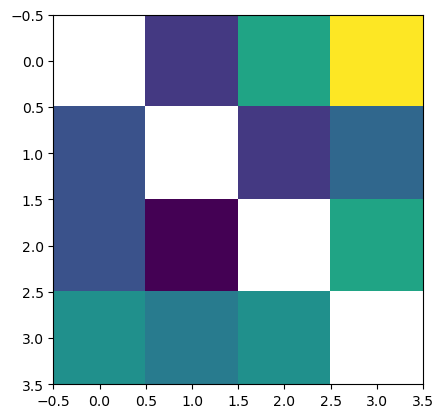

In [145]:
plt.imshow(transitions_all)

In [146]:
np.nansum(transitions_all)

57.0

### Investigate another session

In [317]:
nwb_file_name = 'lewis20240109.nwb'
nwb_copy_file_name=get_nwb_copy_filename(nwb_file_name)
session_interval, position_interval = runSessionNames(nwb_copy_file_name)
print(session_interval)

['02_Rev2Session1', '04_Rev2Session2', '06_Rev2Session3', '08_Rev2Session4']


In [318]:
TrialChoiceReplayTransition() & {'nwb_file_name': nwb_copy_file_name}

nwb_file_name name of the NWB file,interval_list_name descriptive name of this interval list,classifier_param_name a name for this set of parameters,encoding_set a name for this set of encoding,"transitions ndarray, for all replayed arm transitions","choice_reward_replay_transition pandas dataframe, choice, reward, replayed arm transitions, ripple time, replays"
lewis20240109_.nwb,02_Rev2Session1,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=,=BLOB=
lewis20240109_.nwb,04_Rev2Session2,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=,=BLOB=
lewis20240109_.nwb,06_Rev2Session3,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=,=BLOB=
lewis20240109_.nwb,08_Rev2Session4,default_decoding_gpu_4armMaze,2Dheadspeed_above_4,=BLOB=,=BLOB=


In [331]:
key = {'nwb_file_name': nwb_copy_file_name,
           'interval_list_name': '08_Rev2Session4',
           'classifier_param_name':'default_decoding_gpu_4armMaze',
           'encoding_set':'2Dheadspeed_above_4'}

T_transition = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

In [332]:
matrix_transition

,0,1,2,3
0,9.0,0.0,0.0,0.0
1,0.0,9.0,0.0,0.0
2,0.0,0.0,4.0,1.0
3,0.0,0.0,1.0,3.0


In [333]:
T_transition[:40]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,replayed_singletons,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
1,1.704842e+09,1.0,1.704842e+09,1.0,[],[],2.0,[],"[[[1704841649.673332, 1704841650.1693316]], [[...",[],"[[[2, 4, 2, 1]], [[1]]]",[],"[0, 1]",1.0,1.0,3.0,NaN,NaN
2,1.704842e+09,1.0,1.704842e+09,3.0,[],[],1.0,"[[[1704841668.2793207, 1704841668.5413206]], [...","[[[1704841684.8313107, 1704841684.9413106]]]","[[[0]], [[0]]]",[[[3]]],"[2, 3]",[4],3.0,3.0,4.0,1.0,1.0
3,1.704842e+09,1.0,1.704842e+09,4.0,[],[],1.0,[],[],[],[],[],[],4.0,4.0,2.0,3.0,1.0
4,NaN,NaN,1.704842e+09,2.0,[],[],0.0,"[[[1704841689.9793077, 1704841690.1793077]], [...","[[[1704841704.0532992, 1704841704.2392993]], [...","[[[0]], [[0]]]","[[[4]], [[4], [4]], [[4], [4]], [[4], [4], [4]...","[5, 24]","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 20, 2...",2.0,2.0,1.0,4.0,1.0
5,1.704842e+09,1.0,1.704842e+09,1.0,[],[],1.0,"[[[1704841760.4812655, 1704841760.793265]], [[...","[[[1704841774.687257, 1704841774.949257]], [[1...","[[[0]], [[0]], [[0]], [[0]], [[0]], [[0]], [[0...","[[[1]], [[1]], [[1]]]","[25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 38]","[35, 36, 37]",1.0,1.0,3.0,2.0,1.0
6,1.704842e+09,1.0,1.704842e+09,3.0,[],[],1.0,[],[],[],[],[],[],3.0,3.0,2.0,1.0,1.0
7,1.704842e+09,1.0,1.704842e+09,2.0,[],[],2.0,"[[[1704841806.595238, 1704841806.7932377]], [[...","[[[1704841819.9452298, 1704841820.2172296]], [...","[[[0]], [[0]], [[0]]]","[[[2]], [[2]], [[2]], [[2]]]","[39, 40, 41]","[42, 43, 44, 45]",2.0,2.0,3.0,3.0,1.0
8,1.704842e+09,1.0,1.704842e+09,3.0,[],[],1.0,[],"[[[1704841851.781211, 1704841852.0492103]], [[...",[],"[[[3]], [[3]]]",[],"[46, 47]",3.0,3.0,4.0,2.0,2.0
9,1.704842e+09,1.0,1.704842e+09,4.0,[],[1],2.0,"[[[1704841861.6412048, 1704841861.8692048]], [...","[[[1704841873.9291975, 1704841874.4011972]], [...","[[[0]], [[0], [1]]]","[[[4]], [[0, 4]]]","[48, 49]","[50, 51]",4.0,4.0,1.0,3.0,2.0
10,1.704842e+09,1.0,1.704842e+09,1.0,[],[],1.0,"[[[1704841888.039189, 1704841888.393189]]]","[[[1704841901.7151809, 1704841901.9851809]]]",[[[0]]],[[[1]]],[52],[53],1.0,1.0,2.0,4.0,4.0


In [328]:
T_transition[40:]

,timestamp_H,Home,timestamp_O,OuterWellIndex,replayed_transitions,replayed_singletons,rewardNum,ripple_H,ripple_O,replay_H,replay_O,ripple_ID_H,ripple_ID_O,current,future_H,future_O,past,past_reward
41,1.704834e+09,1.0,1.704834e+09,4.0,[],[],1.0,"[[[1704833724.8675556, 1704833725.0915554]], [...","[[[1704833732.31155, 1704833732.4375496]], [[1...","[[[0]], [[0]]]","[[[4]], [[4]], [[4]], [[4]]]","[153, 154]","[155, 156, 157, 158]",4.0,4.0,2.0,1.0,1.0
42,1.704834e+09,1.0,1.704834e+09,2.0,[],[],2.0,"[[[1704833741.091543, 1704833741.3735428]], [[...","[[[1704833761.8055272, 1704833762.063527], [17...","[[[0]], [[0]], [[0], []]]","[[[2], [2]]]","[159, 160, 161]",[163],2.0,2.0,3.0,4.0,1.0
43,1.704834e+09,1.0,1.704834e+09,3.0,[],[2],1.0,"[[[1704833769.6775212, 1704833769.925521]], [[...","[[[1704833784.7935095, 1704833784.9715097]], [...","[[[0, 2]], [[0]]]","[[[3]], [[3]], [[3]]]","[164, 165]","[166, 167, 168]",3.0,3.0,4.0,2.0,2.0
44,1.704834e+09,1.0,1.704834e+09,4.0,[],[],2.0,"[[[1704833794.1615024, 1704833794.4595022]], [...","[[[1704833813.6274874, 1704833813.7654874]], [...","[[[0]], [[], []], [[0]]]","[[[4]], [[4]], [[4]]]","[169, 170, 171]","[173, 174, 175]",4.0,4.0,3.0,3.0,2.0
45,1.704834e+09,1.0,1.704834e+09,3.0,[],[],2.0,"[[[1704833829.889475, 1704833830.0114748], [17...","[[[1704833846.2994623, 1704833846.4854622]], [...","[[[0], []]]","[[[3]], [[3]], [[3]]]",[176],"[177, 178, 179]",3.0,3.0,1.0,4.0,4.0
46,1.704834e+09,1.0,1.704834e+09,1.0,[],[],2.0,"[[[1704833859.0094526, 1704833859.2774525]], [...","[[[1704833871.3694432, 1704833871.607443]]]","[[[0]], [[], [], []], [[0]]]",[[[1]]],"[180, 181, 182]",[183],1.0,1.0,2.0,3.0,3.0
47,1.704834e+09,1.0,1.704834e+09,2.0,[],[],2.0,"[[[1704833885.983432, 1704833886.0854318]]]","[[[1704833897.4094234, 1704833897.701423]]]",[[[]]],[[[2]]],[184],[185],2.0,2.0,3.0,1.0,1.0
48,1.704834e+09,1.0,1.704834e+09,3.0,[],[1],1.0,"[[[1704833914.5814102, 1704833914.69141], [170...","[[[1704833929.4393988, 1704833929.7193985]]]","[[[0], []], [[1], [], []], [[0]]]",[[[3]]],"[186, 187, 188]",[190],3.0,3.0,4.0,2.0,2.0
49,1.704834e+09,1.0,1.704834e+09,4.0,[],[2],2.0,"[[[1704833940.3093903, 1704833940.5153902]], [...","[[[1704833951.1253822, 1704833951.3373818]]]","[[[0]], [[2], [], []]]",[[[4]]],"[191, 192]",[194],4.0,4.0,3.0,3.0,2.0
50,1.704834e+09,1.0,1.704834e+09,3.0,[],[],2.0,[],[],[],[],[],[],3.0,3.0,1.0,4.0,4.0


In [273]:
key = {'nwb_file_name': nwb_copy_file_name,
           'interval_list_name': '08_Seq2Session4',
           'classifier_param_name':'default_decoding_gpu_4armMaze',
           'encoding_set':'2Dheadspeed_above_4_andlowmua'}

T_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'choice_reward_replay_transition'))
matrix_transition_ = pd.DataFrame((TrialChoiceReplayTransition() & key).fetch1(
    'transitions'))

DataJointError: fetch1 should only return one tuple. 0 tuples found

In [169]:
matrix_transition_ 

,0,1,2,3
0,13.0,1.0,1.0,1.0
1,2.0,15.0,2.0,2.0
2,1.0,1.0,19.0,0.0
3,2.0,0.0,1.0,3.0


In [170]:
transitions_all

array([[nan,  5.,  4.,  4.],
       [14., nan, 17., 10.],
       [ 4., 16., nan,  5.],
       [ 4.,  3.,  5., nan]])